# Trabajo final de Visión Computacional



*   Erika Tello
*   Diego De Lama 



https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2267-2

https://www.rovile.org/datasets/haploid-and-diploid-maize-seeds-dataset/


## Librerías

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
# Extracción de un .rar
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 5.1 MB/s eta 0:00:00


In [ ]:
# Descarga de dataset
import gdown

# Extracción de un .rar
import patoolib

# Edición de una carpeta de Google Colab
from os import remove, rmdir

# importando librerías empleadas en Transfer Learning
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import plotly.express as px
import time
import copy

## Descarga de dataset

In [ ]:
url = "https://drive.google.com/uc?id=1zPCchZ5g6eDI01_L_RKxjfVrEEAZU2xL"
output = "dataset.rar"
gdown.download(url, output, quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1zPCchZ5g6eDI01_L_RKxjfVrEEAZU2xL
From (redirected): https://drive.google.com/uc?id=1zPCchZ5g6eDI01_L_RKxjfVrEEAZU2xL&confirm=t&uuid=40cd038b-35e6-4ca9-9109-e7f77116ae74
To: /content/dataset.rar
100%|██████████| 43.7M/43.7M [00:00<00:00, 114MB/s] 


'dataset.rar'

In [ ]:
patoolib.extract_archive("dataset.rar") 

patool: Extracting dataset.rar ...
patool: running /usr/bin/unrar x -- /content/dataset.rar
patool:     with cwd='./Unpack_fmm3_lmm'
patool: ... dataset.rar extracted to `dataset' (multiple files in root).


'dataset'

In [ ]:
remove("/content/dataset/citation_files/citation2BibTeX.bib")
remove("/content/dataset/citation_files/citation2RIS.ris")
remove("/content/dataset/citation_files/citation2TEXT.txt")
rmdir("/content/dataset/citation_files")

## Edición del dataset

In [ ]:
dataset = datasets.ImageFolder('dataset',
                              transform=transforms.Compose([
                                  #transforms.RandomResizedCrop(224),
                                  transforms.Resize(255),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])
                                  ]))

class_names = dataset.classes
print(class_names)

['diploid', 'haploid']


## Transfer learning



In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 3000
    Root location: dataset
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
# Particionamos en subconjuntos de entrenamiento y prueba
n_test = int(len(dataset) * 0.2)
n_train = len(dataset) - n_test

train_dataset, test_dataset = random_split(dataset, [n_train, n_test])

print(f'n_train={len(train_dataset)}')
print(f'n_test={len(test_dataset)}')

n_train=2400
n_test=600


In [ ]:
# Particionamos los subconjuntos en minibatches
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)


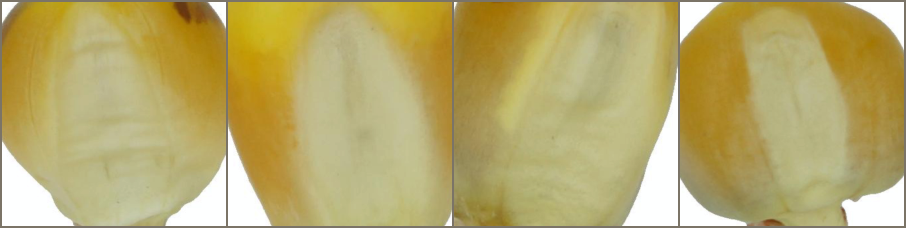

In [ ]:
# Mostramos algunos ejemplos
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  fig = px.imshow(inp, title=title)
  fig.update_layout(title_x=.5)
  fig.show()

inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=', '.join(str(class_names[x]) for x in classes))

In [ ]:
# Función de entrenamiento y validación
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  rs = '------------------------------------------------------------------'
  print('Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best')
  print(rs)
  
  for epoch in range(num_epochs):
    
    # Entrenamiento
    model.train()
    
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
        
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
    
    result = {}
    result['train_loss'] = running_loss /len(train_dataset)
    result['train_acc'] = running_corrects.double() / len(train_dataset)

    scheduler.step()
    
    # Validación 
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
        
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
     
    result['val_loss'] = running_loss /len(test_dataset)
    result['val_acc'] = running_corrects.double() / len(test_dataset)
    epoch_acc = result['val_acc']
      
    st = '          '
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model.state_dict())
      st = '   ***    '
        
    print("%5d %11.4f %11.4f %11.4f %11.4f %s" % (epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc'], st))

  print(rs)
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val accuracy: {best_acc:.4f}')

  model.load_state_dict(best_model_wts)
  return model

  # Mostramos las predicciones
def visualize_model(model, num_images = 8):
  was_training = model.training
  model.eval()
  images_so_far = 0
  
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      
      for j in range(inputs.size()[0]):
        images_so_far += 1
        imshow(inputs.cpu().data[j], f'predicted: {class_names[preds[j]]}')
        
        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode = was_training)

###**Clasificación con modelo Alexnet**

In [ ]:
# Definimos el modelo Alexnet
ft_model_1 = models.alexnet(pretrained=True)
print(ft_model_1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Modificamos la última capa y entrenamos
device = ('cuda' if torch.cuda.is_available() else 'cpu')

for param in ft_model_1.parameters():
  param.requires_grad = False

ft_model_1.classifier[6] = nn.Linear(in_features=4096, out_features=2) #la salida son 2 por haploides y diploides
ft_model_1 = ft_model_1.to(device)

ft_criterion = nn.CrossEntropyLoss()
#ft_optimizer = torch.optim.SGD(ft_model.parameters(), lr=0.01, momentum=0.9)
ft_optimizer = torch.optim.Adam(ft_model_1.parameters(), lr=0.01)
ft_scheduler = torch.optim.lr_scheduler.StepLR(ft_optimizer, step_size=5, gamma=0.1)#cada 7 epocas reduce el learning rate en 7 puntos

ft_model_1 = train_model(ft_model_1, ft_criterion, ft_optimizer, ft_scheduler, num_epochs=25)

Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
    0      2.7239      0.7533      1.4684      0.8567    ***    
    1      2.5190      0.8000      1.4156      0.8683    ***    
    2      2.6387      0.8042      1.2858      0.8883    ***    
    3      2.9946      0.8075      1.5774      0.8517           
    4      3.2883      0.7967      1.6691      0.8550           
    5      2.2561      0.8329      1.3818      0.8733           
    6      1.9003      0.8421      1.2882      0.8633           
    7      1.8163      0.8388      1.1181      0.8783           
    8      1.5470      0.8558      1.2195      0.8750           
    9      1.5696      0.8408      1.0864      0.8883           
   10      1.5340      0.8471      1.0092      0.8867           
   11      1.5100      0.8358      1.0375      0.8850           
   12      1.4618      0.8504      1.0040      0.8817           
   13      1.4922      0.83


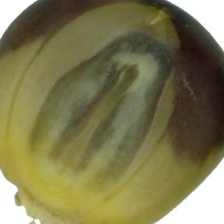


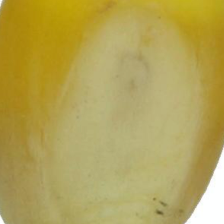


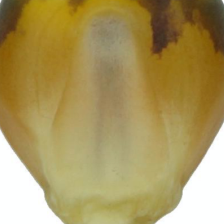


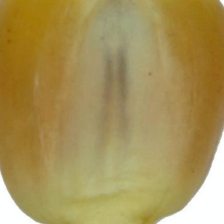


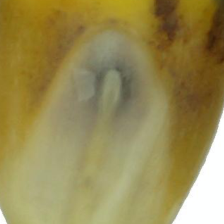


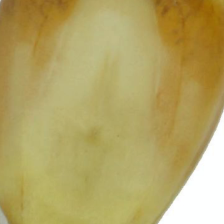


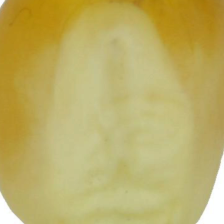


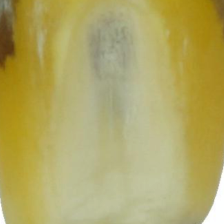

In [ ]:
visualize_model(ft_model_1)

###**Clasificación con Modelo Googlenet**

In [ ]:
# Definimos el modelo Googlenet
ft_model_2 = models.googlenet(pretrained=True)
print(ft_model_2)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
# Modificamos la última capa y entrenamos
device = ('cuda' if torch.cuda.is_available() else 'cpu')

for param in ft_model_2.parameters():
  param.requires_grad = False
ft_model_2.fc = nn.Linear(in_features=1024, out_features=2) #la salida son 2 por haploides y diploides
ft_model_2 = ft_model_2.to(device)

ft_criterion = nn.CrossEntropyLoss()
#ft_optimizer = torch.optim.SGD(ft_model.parameters(), lr=0.002, momentum=0.9)
ft_optimizer = torch.optim.Adam(ft_model_2.parameters(), lr=0.001)

ft_scheduler = torch.optim.lr_scheduler.StepLR(ft_optimizer, step_size=5, gamma=0.1)#cada 7 epocas reduce el learning rate en 7 puntos

ft_model_2 = train_model(ft_model_2, ft_criterion, ft_optimizer, ft_scheduler, num_epochs=25)

Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
    0      0.5713      0.6896      0.4912      0.7350    ***    
    1      0.5345      0.7329      0.4243      0.8083    ***    
    2      0.4885      0.7608      0.4170      0.8033           
    3      0.4930      0.7583      0.4731      0.7767           
    4      0.5088      0.7525      0.3612      0.8500    ***    
    5      0.4321      0.8058      0.3945      0.8150           
    6      0.4519      0.7838      0.3881      0.8400           
    7      0.4549      0.7721      0.3763      0.8367           
    8      0.4492      0.7812      0.3737      0.8433           
    9      0.4631      0.7758      0.3648      0.8400           
   10      0.4555      0.7800      0.3762      0.8317           
   11      0.4442      0.7900      0.3725      0.8450           
   12      0.4473      0.7875      0.3847      0.8250           
   13      0.4462      0.78


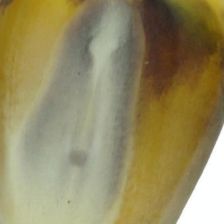


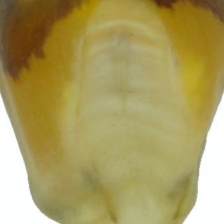


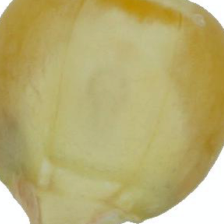


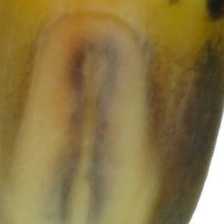


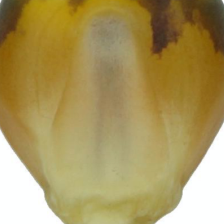


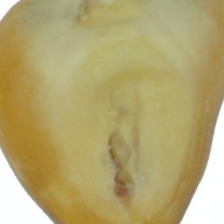


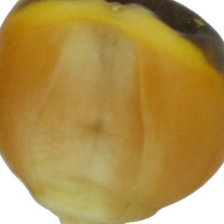


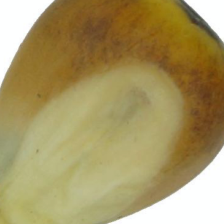

In [ ]:
visualize_model(ft_model_2)

###**Clasificación con modelo VGG Net**

In [ ]:
ft_model_3 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)

print(ft_model_3)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
# Modificamos la última capa y entrenamos
device = ('cuda' if torch.cuda.is_available() else 'cpu')
for param in ft_model_3.parameters():
  param.requires_grad = False
ft_model_3.classifier[6] = nn.Linear(in_features=4096, out_features=2) #la salida son 2 por haploides y diploides
ft_model_3 = ft_model_3.to(device)

ft_criterion = nn.CrossEntropyLoss()
#ft_optimizer = torch.optim.SGD(ft_model.parameters(), lr=0.01, momentum=0.9)
ft_optimizer = torch.optim.Adam(ft_model_3.parameters(), lr=0.01)
ft_scheduler = torch.optim.lr_scheduler.StepLR(ft_optimizer, step_size=5, gamma=0.1)#cada 7 epocas reduce el learning rate en 7 puntos

ft_model_3 = train_model(ft_model_3, ft_criterion, ft_optimizer, ft_scheduler, num_epochs=25)

Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
    0      2.8222      0.6983      1.3967      0.7733    ***    
    1      3.4332      0.7333      1.2955      0.8417    ***    
    2      3.5718      0.7463      3.0119      0.7250           
    3      3.9069      0.7367      3.7776      0.6650           
    4      3.7288      0.7483      2.2555      0.7517           
    5      3.3626      0.7846      1.2439      0.8350           
    6      3.2179      0.7733      1.0247      0.8483    ***    
    7      2.9108      0.7892      0.9762      0.8467           
    8      2.8843      0.7792      0.9737      0.8433           
    9      2.6314      0.7904      0.9195      0.8383           
   10      2.4677      0.7896      0.8565      0.8633    ***    
   11      2.4779      0.7917      0.8684      0.8750    ***    
   12      2.6667      0.7675      0.8718      0.8717           
   13      2.4007      0.78


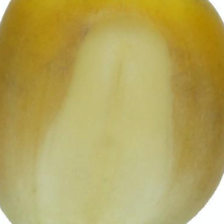


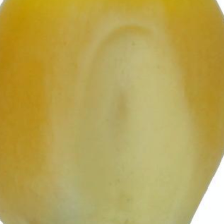


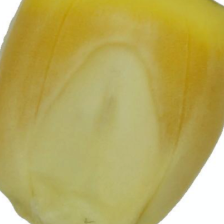


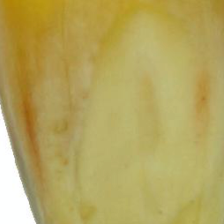


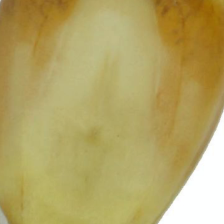


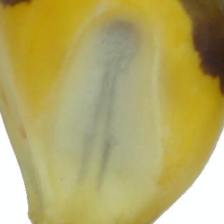


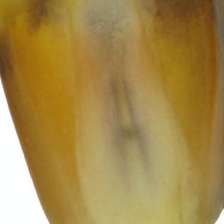


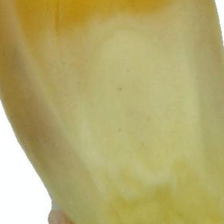

In [ ]:
visualize_model(ft_model_3)

###**Clasificiación** **con** **Resnet** **18**

In [ ]:
# Definimos el modelo Resnet18
ft_model_4 = models.resnet18(pretrained=True)
print(ft_model_4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Modificamos la última capa y entrenamos
device = ('cuda' if torch.cuda.is_available() else 'cpu')
#for param in ft_model_4.parameters():
#  param.requires_grad = False
ft_model_4.fc = nn.Linear(in_features=512, out_features=2) #la salida son 2 por haploides y diploides
ft_model_4 = ft_model_4.to(device)

ft_criterion = nn.CrossEntropyLoss()
ft_optimizer = torch.optim.SGD(ft_model_4.parameters(), lr=0.001, momentum=0.9)
ft_scheduler = torch.optim.lr_scheduler.StepLR(ft_optimizer, step_size=7, gamma=0.1)#cada 7 epocas reduce el learning rate en 7 puntos

ft_model_4 = train_model(ft_model_4, ft_criterion, ft_optimizer, ft_scheduler, num_epochs=25)

Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
    0      0.4701      0.8421      0.1433      0.9467    ***    
    1      0.2935      0.9008      0.1243      0.9500    ***    
    2      0.2632      0.9192      0.2073      0.9067           
    3      0.1710      0.9442      0.1442      0.9400           
    4      0.1815      0.9425      0.1305      0.9450           
    5      0.1224      0.9608      0.1357      0.9450           
    6      0.1162      0.9658      0.1445      0.9467           
    7      0.0590      0.9842      0.1434      0.9417           
    8      0.0422      0.9879      0.1419      0.9433           
    9      0.0435      0.9904      0.1440      0.9400           
   10      0.0306      0.9908      0.1498      0.9417           
   11      0.0298      0.9925      0.1497      0.9383           
   12      0.0324      0.9925      0.1407      0.9450           
   13      0.0255      0.99


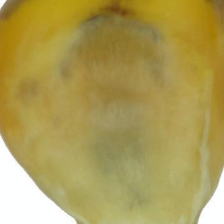


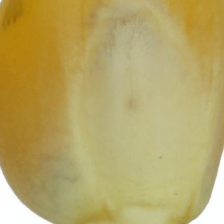


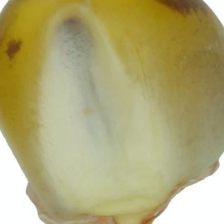


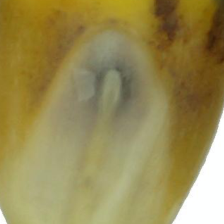


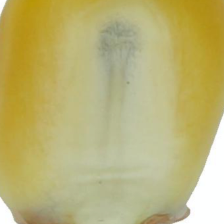


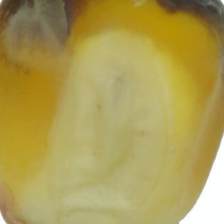


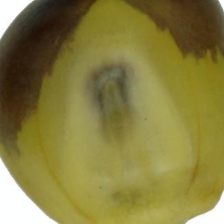


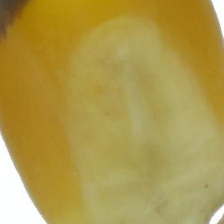

In [ ]:
visualize_model(ft_model_4)

###**Clasificiación** **con** **Resnet** **50**

In [ ]:
# Definimos el modelo Resnet50
ft_model_5 = models.resnet50(pretrained=True)
print(ft_model_5)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Modificamos la última capa y entrenamos
device = ('cuda' if torch.cuda.is_available() else 'cpu')
for param in ft_model_4.parameters():
 param.requires_grad = False

ft_model_5.fc = nn.Linear(in_features=2048, out_features=2) #la salida son 2 por haploides y diploides
ft_model_5 = ft_model_5.to(device)

ft_criterion = nn.CrossEntropyLoss()
#ft_optimizer = torch.optim.SGD(ft_model.parameters(), lr=0.001, momentum=0.9)
ft_optimizer = torch.optim.Adam(ft_model_5.parameters(), lr=0.001)
ft_scheduler = torch.optim.lr_scheduler.StepLR(ft_optimizer, step_size=5, gamma=0.1)#cada 7 epocas reduce el learning rate en 7 puntos

ft_model_5 = train_model(ft_model_5, ft_criterion, ft_optimizer, ft_scheduler, num_epochs=25)

Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
    0      0.4742      0.7988      0.2870      0.8883    ***    
    1      0.3773      0.8475      0.2634      0.9183    ***    
    2      0.3173      0.8746      0.1865      0.9367    ***    
    3      0.3163      0.8729      0.2581      0.9300           
    4      0.2782      0.8888      0.2275      0.9183           
    5      0.2034      0.9204      0.1528      0.9417    ***    
    6      0.1827      0.9313      0.1603      0.9433    ***    
    7      0.1624      0.9354      0.1854      0.9350           
    8      0.1517      0.9388      0.1346      0.9467    ***    
    9      0.1442      0.9458      0.1355      0.9533    ***    
   10      0.1384      0.9429      0.1450      0.9467           
   11      0.1341      0.9442      0.1444      0.9433           
   12      0.1323      0.9496      0.1438      0.9450           
   13      0.1293      0.94


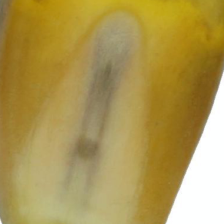


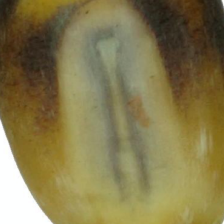


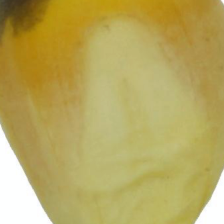


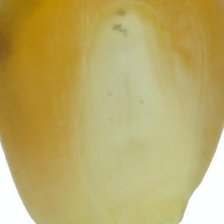


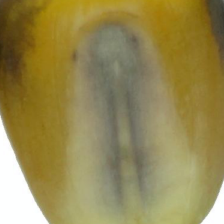


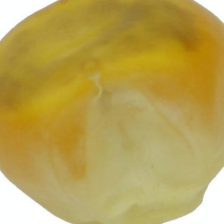


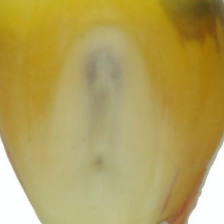


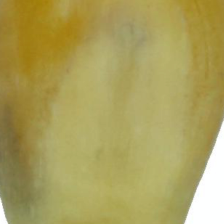

In [ ]:
visualize_model(ft_model_5)

## Deteccion de objetos
[Object detection model](https://www.analyticsvidhya.com/blog/2021/06/simplest-way-to-do-object-detection-on-custom-datasets/)

### Librerías utilizadas

In [ ]:
#print(torch.cude.is_available())

In [ ]:
!pip install detecto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from detecto import core, utils, visualize
from detecto.visualize import show_labeled_image, plot_prediction_grid
from torchvision import transforms
import matplotlib.pyplot as plt

import gdown

### Dataset de entrenamiento

In [ ]:
# Descarga de dataset

url = "https://drive.google.com/drive/folders/1pP4Qr6kOOHgbqOjGmTCrAUHX4s_eog0F"
#output = "Train1"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/Train/collage_1.JPG',
 '/content/Train/collage_1.xml',
 '/content/Train/collage_2.JPG',
 '/content/Train/collage_2.xml',
 '/content/Train/collage_3.JPG',
 '/content/Train/collage_3.xml',
 '/content/Train/collage_4.JPG',
 '/content/Train/collage_4.xml',
 '/content/Train/collage_5.JPG',
 '/content/Train/collage_5.xml',
 '/content/Train/collage_6.JPG',
 '/content/Train/collage_6.xml',
 '/content/Train/collage_7.JPG',
 '/content/Train/collage_7.xml',
 '/content/Train/collage_8.JPG',
 '/content/Train/collage_8.xml',
 '/content/Train/collage_9.JPG',
 '/content/Train/collage_9.xml',
 '/content/Train/collage_10.JPG',
 '/content/Train/collage_10.xml',
 '/content/Train/collage_11.JPG',
 '/content/Train/collage_11.xml',
 '/content/Train/collage_12.JPG',
 '/content/Train/collage_12.xml',
 '/content/Train/collage_13.JPG',
 '/content/Train/collage_13.xml',
 '/content/Train/collage_14.JPG',
 '/content/Train/collage_14.xml',
 '/content/Train/collage_15.JPG',
 '/content/Train/collage_15.xml'

### Dataset de validación

In [ ]:
url ="https://drive.google.com/drive/folders/19JKYfezO5nU6jLJNX2JfCJhmHkazLU-V"
#output = "Train1"
gdown.download_folder(url, quiet=True, use_cookies=False)
#gdown.download(url, output, quiet=False)

['/content/Validation/test_1.JPG',
 '/content/Validation/test_1.xml',
 '/content/Validation/test_2.JPG',
 '/content/Validation/test_2.xml',
 '/content/Validation/test_3.JPG',
 '/content/Validation/test_3.xml',
 '/content/Validation/test_4.JPG',
 '/content/Validation/test_4.xml',
 '/content/Validation/test_5.JPG',
 '/content/Validation/test_5.xml',
 '/content/Validation/test_6.JPG',
 '/content/Validation/test_6.xml',
 '/content/Validation/test_7.JPG',
 '/content/Validation/test_7.xml',
 '/content/Validation/test_8.JPG',
 '/content/Validation/test_8.xml',
 '/content/Validation/test_9.JPG',
 '/content/Validation/test_9.xml',
 '/content/Validation/test_10.JPG',
 '/content/Validation/test_10.xml',
 '/content/Validation/test_11.JPG',
 '/content/Validation/test_11.xml',
 '/content/Validation/test_12.JPG',
 '/content/Validation/test_12.xml',
 '/content/Validation/test_13.JPG',
 '/content/Validation/test_13.xml',
 '/content/Validation/test_14.JPG',
 '/content/Validation/test_14.xml',
 '/content

### Dataset de testeo

In [ ]:
url = "https://drive.google.com/drive/folders/1F5gyfb0HMZtnoZBiLo3fi2ZUzDpmKKye"
#url ="https://drive.google.com/drive/folders/1MounTj8sRqETEopqdAvqchLjwdgmaDiz"
#output = "Train1"
gdown.download_folder(url, quiet=True, use_cookies=False)
#gdown.download(url, output, quiet=False)

['/content/Test/test (1).jpg',
 '/content/Test/test (1).xml',
 '/content/Test/test (2).jpg',
 '/content/Test/test (2).xml',
 '/content/Test/test (3).jpg',
 '/content/Test/test (3).xml',
 '/content/Test/test (4).jpg',
 '/content/Test/test (4).xml',
 '/content/Test/test (5).jpg',
 '/content/Test/test (5).xml',
 '/content/Test/test (6).jpg',
 '/content/Test/test (6).xml',
 '/content/Test/test (7).jpg',
 '/content/Test/test (7).xml',
 '/content/Test/test (8).jpg',
 '/content/Test/test (8).xml',
 '/content/Test/test (9).jpg',
 '/content/Test/test (9).xml',
 '/content/Test/test (10).jpg',
 '/content/Test/test (10).xml',
 '/content/Test/test (11).jpg',
 '/content/Test/test (11).xml',
 '/content/Test/test (12).jpg',
 '/content/Test/test (12).xml',
 '/content/Test/test (13).jpg',
 '/content/Test/test (13).xml',
 '/content/Test/test (14).jpg',
 '/content/Test/test (14).xml',
 '/content/Test/test (15).jpg',
 '/content/Test/test (15).xml',
 '/content/Test/test (16).jpg',
 '/content/Test/test (16).

### Entrenamiento del modelo de detección de objetos

In [ ]:
custom_transforms = transforms.Compose([
transforms.ToPILImage(),
transforms.Resize(600),
transforms.RandomHorizontalFlip(0.5),
transforms.ColorJitter(saturation=0.2),
transforms.ToTensor(),
utils.normalize_transform(),
])

In [ ]:
Train_dataset=core.Dataset('Train/',transform=custom_transforms)#L1
Val_dataset = core.Dataset('Validation/',transform=custom_transforms)#L2
loader=core.DataLoader(Val_dataset, batch_size=2, shuffle=True)#L3
model = core.Model(['diploid','haploid'])#L4
losses = model.fit(loader, Val_dataset, epochs=25, lr_step_size=5, learning_rate=0.001, verbose=True)#L5

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Epoch 1 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.49it/s]


Loss: 1.3737346708774567
Epoch 2 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.43it/s]


Loss: 0.9911261469125747
Epoch 3 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


Loss: 0.8768787920475006
Epoch 4 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


Loss: 0.7939790993928909
Epoch 5 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


Loss: 0.7648815214633942
Epoch 6 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.33it/s]


Loss: 0.7240429669618607
Epoch 7 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


Loss: 0.7064380943775177
Epoch 8 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.43it/s]


Loss: 0.6952283322811127
Epoch 9 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


Loss: 0.6877465695142746
Epoch 10 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


Loss: 0.690181702375412
Epoch 11 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


Loss: 0.6791790753602982
Epoch 12 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.50it/s]


Loss: 0.6887301743030548
Epoch 13 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.41it/s]


Loss: 0.6769111335277558
Epoch 14 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.39it/s]


Loss: 0.6744391530752182
Epoch 15 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


Loss: 0.6753225237131119
Epoch 16 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.39it/s]


Loss: 0.683249431848526
Epoch 17 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


Loss: 0.6788808584213257
Epoch 18 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.40it/s]


Loss: 0.6730690747499466
Epoch 19 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


Loss: 0.6796612814068794
Epoch 20 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.40it/s]


Loss: 0.6805542290210724
Epoch 21 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.43it/s]


Loss: 0.6763358175754547
Epoch 22 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


Loss: 0.6735498607158661
Epoch 23 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


Loss: 0.6785328209400177
Epoch 24 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.43it/s]


Loss: 0.6803288042545319
Epoch 25 of 25
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.49it/s]

Loss: 0.6769097983837128


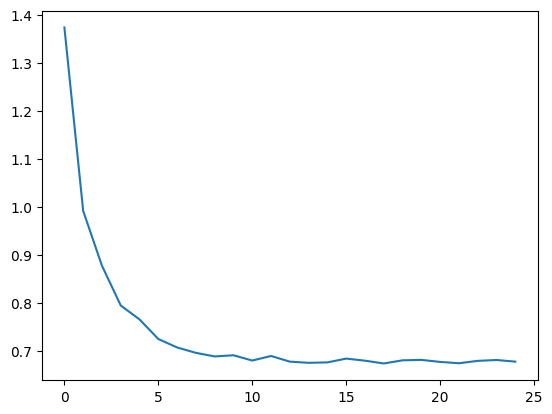

In [ ]:
# Gráfico de pérdidas en el dataset de validación vs. Número de épocas
plt.plot(losses)
plt.show()

In [ ]:
Train_dataset=core.Dataset('Train/',transform=custom_transforms)#L1
Val_dataset = core.Dataset('Validation/',transform=custom_transforms)#L2
loader=core.DataLoader(Val_dataset, batch_size=2, shuffle=True)#L3
model = core.Model(['diploid','haploid'])#L4
losses = model.fit(loader, Val_dataset, epochs=12, lr_step_size=5, learning_rate=0.001, verbose=True)#L5

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.



Epoch 1 of 12
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.41it/s]


Loss: 1.3847642421722413
Epoch 2 of 12
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


Loss: 1.0409749925136567
Epoch 3 of 12
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.31it/s]


Loss: 0.861366280913353
Epoch 4 of 12
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.51it/s]


Loss: 0.760265338420868
Epoch 5 of 12
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.51it/s]


Loss: 0.694659611582756
Epoch 6 of 12
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


Loss: 0.6662995845079422
Epoch 7 of 12
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.39it/s]


Loss: 0.6498979955911637
Epoch 8 of 12
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.44it/s]


Loss: 0.6520638078451156
Epoch 9 of 12
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


Loss: 0.6444331467151642
Epoch 10 of 12
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


Loss: 0.636452141404152
Epoch 11 of 12
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Loss: 0.6399580091238022
Epoch 12 of 12
Begin iterating over training dataset


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Begin iterating over validation dataset


100%|██████████| 20/20 [00:03<00:00,  5.50it/s]

Loss: 0.6398107081651687


In [ ]:
model.save('model_weights.pth')
model = core.Model.load('model_weights.pth', ['diploid', 'haploid'])

### Pruebas del modelo de detección de objetos

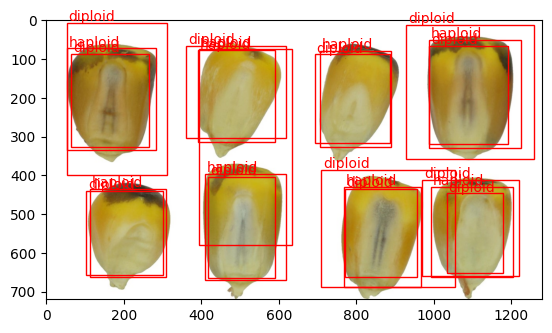

In [ ]:
image = utils.read_image('Validation/test_1.JPG') 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)

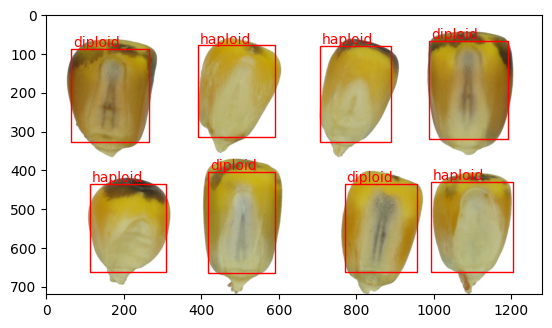

In [ ]:
thresh=0.62
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)

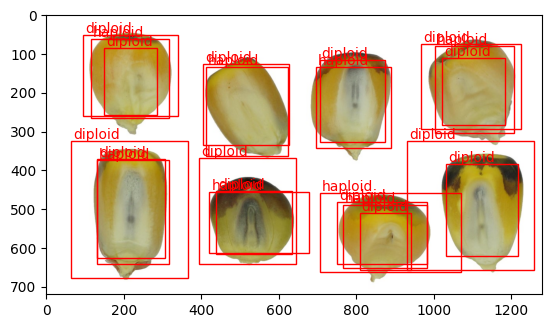

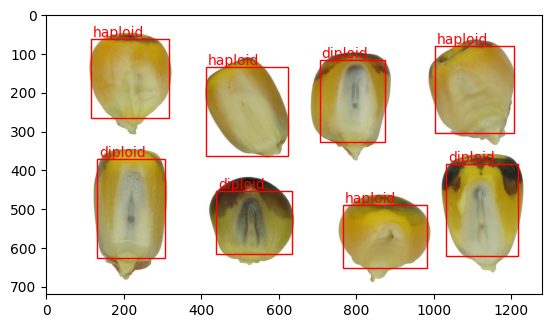

In [ ]:
image = utils.read_image('Validation/test_12.JPG') 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)
thresh=0.62
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)

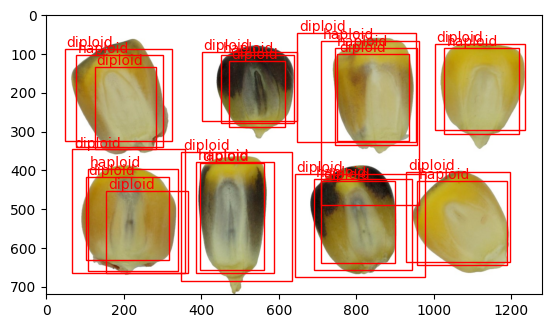

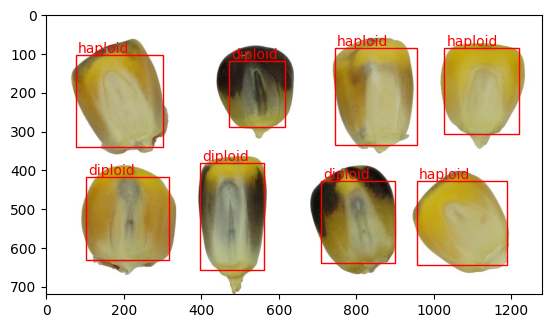

In [ ]:
image = utils.read_image('Validation/test_19.JPG') 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)
thresh=0.57
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)

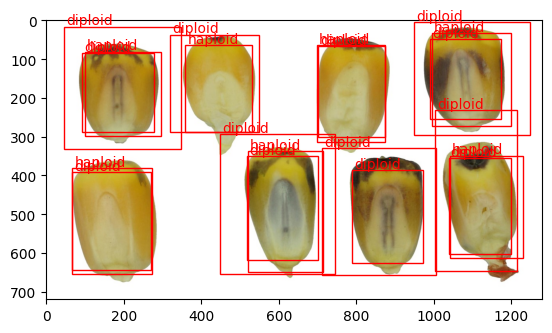

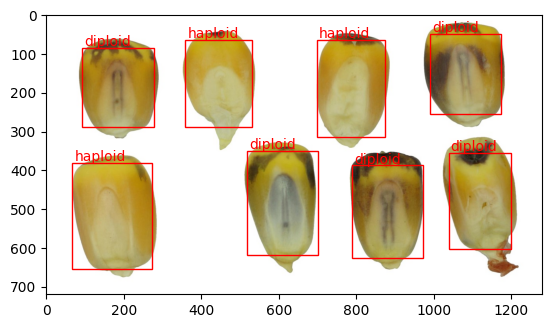

In [ ]:
image = utils.read_image('Validation/test_15.JPG') 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)
thresh=0.57
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)

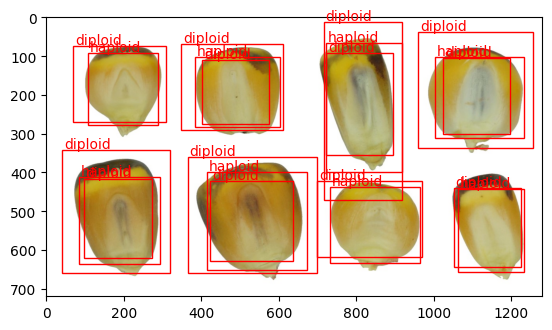

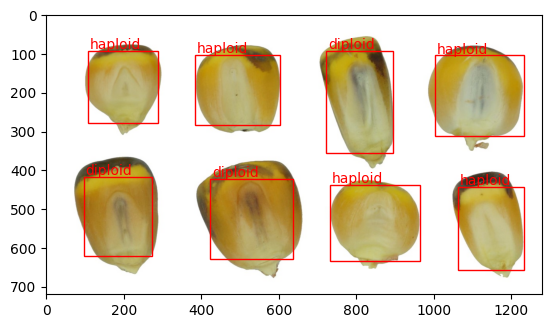

In [ ]:
image = utils.read_image('Validation/test_7.JPG') 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)
thresh=0.57
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)

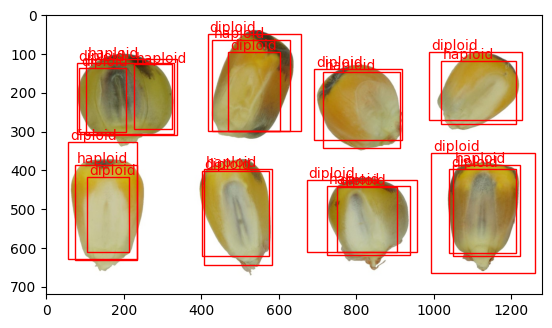

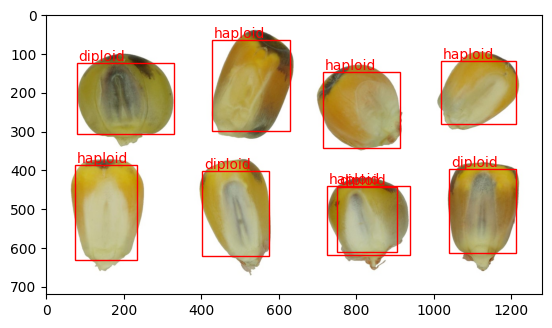

In [ ]:
image = utils.read_image('Validation/test_11.JPG') 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)
thresh=0.62
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)

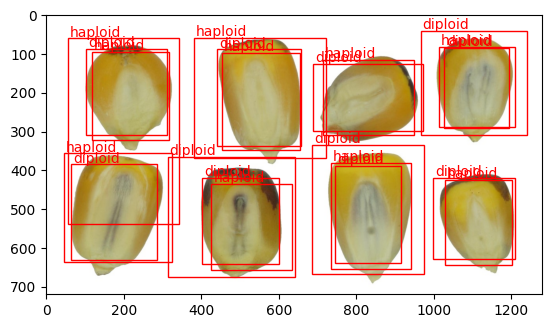

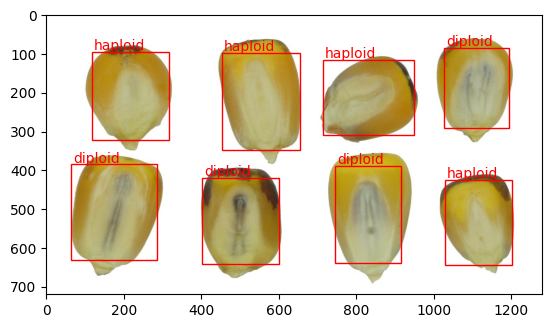

In [ ]:
image = utils.read_image('Validation/test_4.JPG') 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)
thresh=0.62
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)

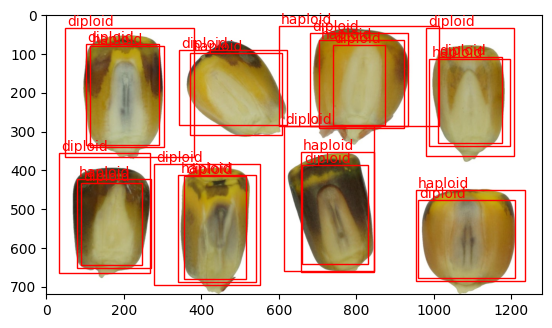

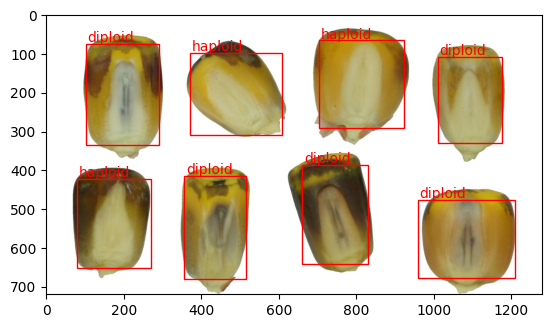

In [ ]:
image = utils.read_image('Validation/test_16.JPG') 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)
thresh=0.58
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)

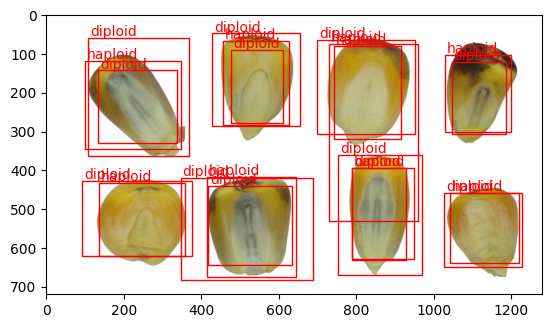

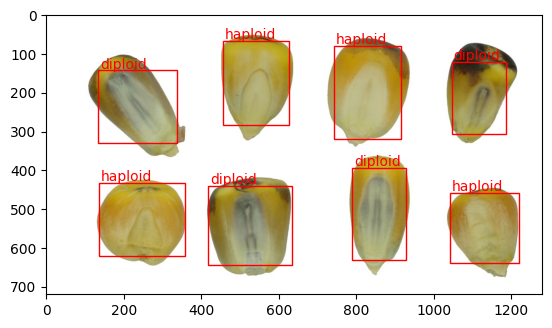

In [ ]:
image = utils.read_image('Validation/test_2.JPG') 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)
thresh=0.62
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)

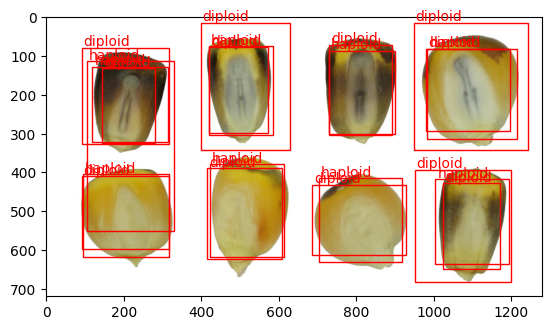

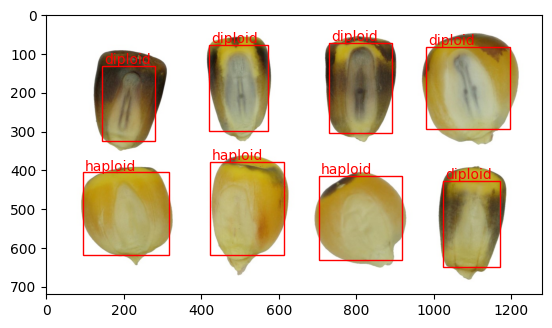

In [ ]:
image = utils.read_image('Validation/test_20.JPG') 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)
thresh=0.62
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)

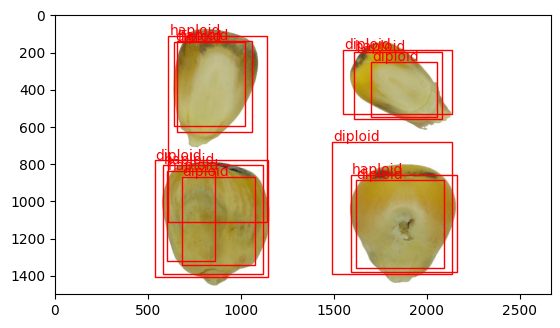

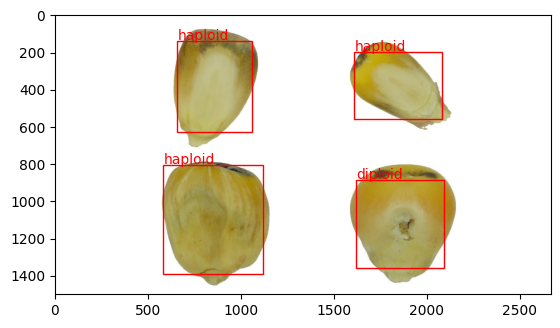

In [ ]:
image = utils.read_image('Test/test (18).jpg') 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)
thresh=0.62
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)

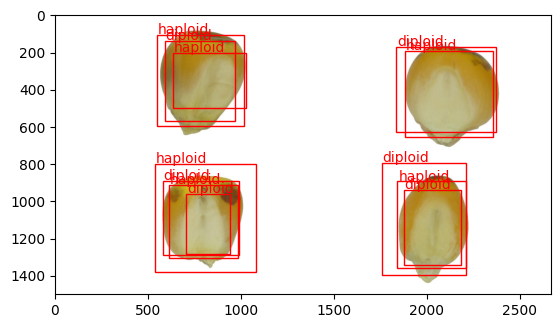

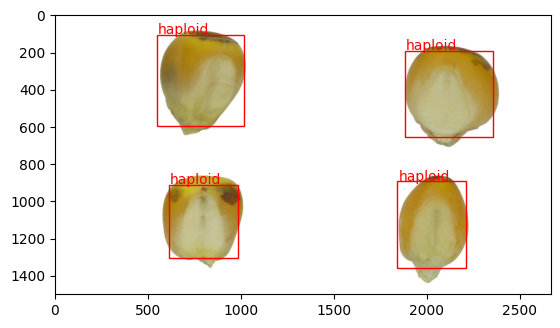

In [ ]:
image = utils.read_image('Test/test (10).jpg') 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)
thresh=0.62
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)

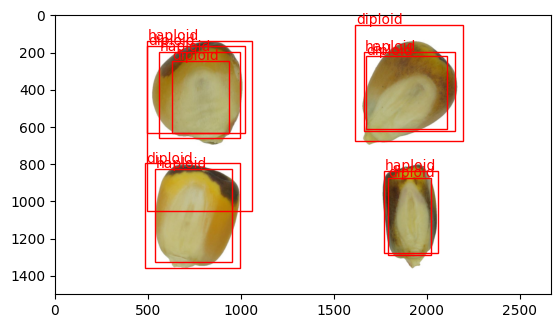

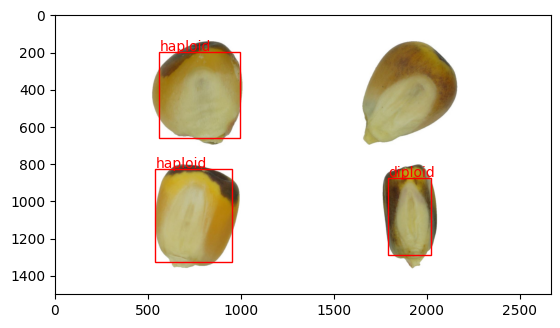

In [ ]:
image = utils.read_image('Test/test (6).jpg') 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)
thresh=0.62
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)

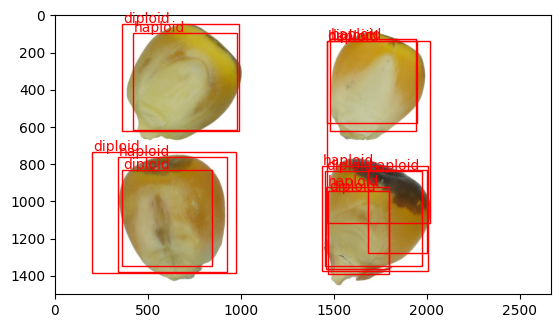

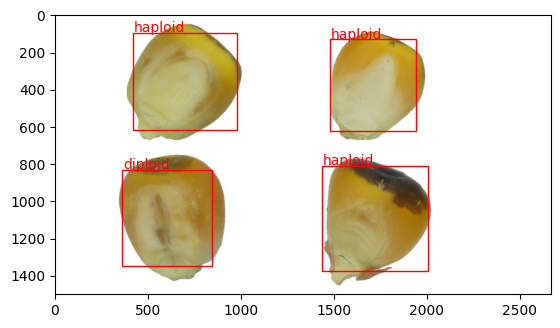

In [ ]:
image = utils.read_image('Test/test (17).jpg') 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)
thresh=0.62
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)